In [1]:
import os
import ast
import glob
import numpy as np
import pandas as pd
import scipy.signal
import matplotlib.pyplot as plt

# Note:     (kl loss) 0 <= alpha <= 1 (next_token loss)

In [7]:
# Load files
multiple = True

csv_log_dir = "/scratch/ssd004/scratch/klambert/slm_ensembles/csv_logs"
subdir = "13-06-2025"
filename = "lr1e-5_hyperparameters_metrics.csv"
exclude = ["lr4e-3_hyperparameters_metrics"]

if multiple:
    csv_full_dir = os.path.join(csv_log_dir, subdir)
    csv_files = glob.glob(os.path.join(csv_full_dir, "*.csv"))
    
    dfs = {}
    for filepath in csv_files:        
        name = os.path.splitext(os.path.basename(filepath))[0]
        if name in exclude:
            continue
        
        df = pd.read_csv(filepath)
        df["source"] = name
        dfs[name] = df
    combined_df = pd.concat(dfs.values(), ignore_index=True)
else:
    file_path = os.path.join(csv_log_dir, subdir, filename)

    dfs = {}
    df = pd.read_csv(file_path)
    df["source"] = filename
    dfs[filename] = df
    combined_df = pd.concat(dfs.values(), ignore_index=True)

print(combined_df["source"].value_counts())


source
lr1e-5_hyperparameters_metrics    89
lr5e-5_hyperparameters_metrics    89
lr1e-4_hyperparameters_metrics    89
lr5e-6_hyperparameters_metrics    89
Name: count, dtype: int64


In [8]:
# Add synthetic round_num if missing
# if "round_num" not in df.columns or df["round_num"].isnull().all():
#     if "phase" in df.columns and "role" in df.columns:
#         df["role"] = df["role"].astype(str).str.strip()
#         df["phase"] = df["phase"].astype(str).str.strip()
# 
#         def assign_rounds(group):
#             group = group.copy()
#             group["round_num"] = range(len(group))
#             return group
# 
#         df = df.groupby(["phase", "role"]).apply(assign_rounds).reset_index(drop=True)
# 
# dfs[name] = df

In [9]:
for name, df in dfs.items():
    metadata_str = df[df["metadata"].notna()]["metadata"].iloc[0]
    metadata = ast.literal_eval(metadata_str)

    print(f"\n==== METADATA FROM {name} ====")
    print(f"Run ID String: {metadata.get('ID string', 'N/A')}")
    print(f"Run Description: {metadata.get('Description', 'N/A')}\n")

    for key, value in metadata.items():
        print(f"{key}: {value}")


==== METADATA FROM lr1e-5_hyperparameters_metrics ====
Run ID String: Experiment with hyperparameters for faster convergence to 0 loss
Run Description: Learning rate tweaking: lr = 1e-5

Custom run name: lr1e-5_hyperparameters
Description: Learning rate tweaking: lr = 1e-5
Teacher Model: Qwen/Qwen2.5-7B-Instruct
Student Model: Qwen/Qwen2.5-0.5B-Instruct
Dataset Name: allenai/tulu-3-sft-mixture
Dataset Type: single
Alpha: 1
Learning rate: 1e-05
Total Rounds: 1
Steps per Round: 1200
Eval batch size: 4
Start Time: 2025-06-13 21:00:40
Model Save Dir: /projects/distilling_llms/model_log/13-06-2025/run_16_lr1e-5_hyperparameters
ID string: Experiment with hyperparameters for faster convergence to 0 loss

==== METADATA FROM lr5e-5_hyperparameters_metrics ====
Run ID String: Experiment with hyperparameters for faster convergence to 0 loss
Run Description: Learning rate tweaking: lr = 5e-5

Custom run name: lr5e-5_hyperparameters
Description: Learning rate tweaking: lr = 5e-5
Teacher Model: Qwe

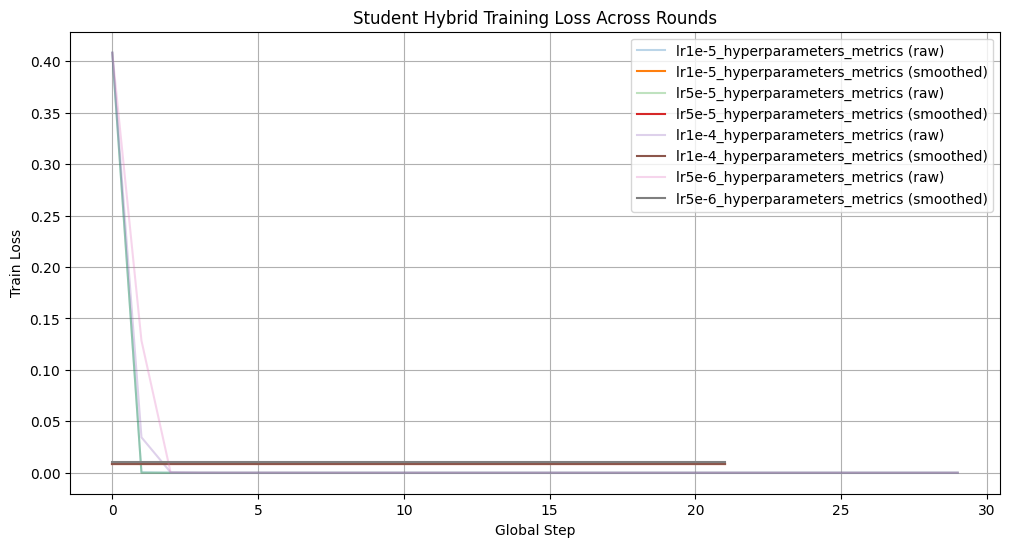

In [10]:
# Student train loss (hybrid) over rounds
side_by_side = False

filter_size = 51
kernel = np.ones(filter_size) / filter_size


if not side_by_side:
    plt.figure(figsize=(12, 6))

    for name, df in dfs.items():
        student_train_df = df[
            (df["role"] == "student") &
            (df["phase"] == "train") &
            (df["function"] == "compute_loss")
        ]

        loss = student_train_df["train_loss"].to_numpy()
        smoothed = scipy.signal.fftconvolve(loss, kernel, mode="valid")

        plt.plot(range(len(loss)), loss, alpha=0.3, label=f"{name} (raw)")
        plt.plot(range(len(smoothed)), smoothed, label=f"{name} (smoothed)")


    plt.title("Student Hybrid Training Loss Across Rounds")
    plt.xlabel("Global Step")
    plt.ylabel("Train Loss")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    num_files = len(dfs)
    cols = min(num_files, 3)
    rows = (num_files + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 4 * rows), squeeze=False)
    
    for idx, (name, df) in enumerate(dfs.items()):
        row, col = divmod(idx, cols)
        ax = axes[row][col]

        student_train_df = df[
            (df["role"] == "student") &
            (df["phase"] == "train") &
            (df["function"] == "compute_loss")
        ]

        loss = student_train_df["train_loss"].to_numpy()
        if len(loss) < filter_size:
            ax.set_title(f"{name} (too short)")
            ax.axis("off")
            continue

        smoothed = scipy.signal.fftconvolve(loss, kernel, mode="valid")

        ax.plot(range(len(loss)), loss, alpha=0.3, label="Raw")
        ax.plot(range(len(smoothed)), smoothed, label="Smoothed")
        ax.set_title(f"Training Loss: {name}")
        ax.set_xlabel("Global Step")
        ax.set_ylabel("Train Loss")
        ax.legend()

    # Hide any unused subplots
    for i in range(idx + 1, rows * cols):
        row, col = divmod(i, cols)
        axes[row][col].axis("off")

    plt.tight_layout()
    plt.show()
    
    
    


In [ ]:
# Student train loss (kl) over rounds
filter_size = 51
kernel = np.ones(filter_size) / filter_size

plt.figure(figsize=(12, 6))

for name, df in dfs.items():
    student_train_df = df[
        (df["role"] == "student") &
        (df["phase"] == "train") &
        (df["function"] == "compute_loss")
    ]

    loss = student_train_df["train_kl_loss"].to_numpy()
    smoothed = scipy.signal.fftconvolve(loss, kernel, mode="valid")

    plt.plot(loss, alpha=0.3, label=f"{name} (raw)")
    plt.plot(smoothed, label=f"{name} (smoothed)")

plt.title("Student KL Training Loss Across Rounds")
plt.xlabel("Global Step")
plt.ylabel("KL Loss")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Student train loss (next token) over rounds
plt.figure(figsize=(12, 6))

for name, df in dfs.items():
    student_train_df = df[
        (df["role"] == "student") &
        (df["phase"] == "train") &
        (df["function"] == "compute_loss")
    ].sort_values(by=["round_num", "step"]).reset_index(drop=True)

    student_train_df["global_step"] = range(len(student_train_df))
    smoothed_loss = scipy.signal.medfilt(student_train_df["train_next_token_loss"], 31)

    plt.plot(student_train_df["global_step"], smoothed_loss, label=f"{name}")

plt.title("Student Next Token Loss Across Rounds")
plt.xlabel("Global Step")
plt.ylabel("Train Loss")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Per round logging of training loss ?

In [ ]:
# Per round logging of student LM eval loss
plt.figure(figsize=(12, 6))

for name, df in dfs.items():
    student_eval_df = df[
        (df["role"] == "student") &
        (df["phase"] == "eval") &
        (df["function"] == "prediction_step")
    ].sort_values(by=["round_num", "step"]).reset_index(drop=True)

    student_eval_df["global_step"] = range(len(student_eval_df))
    smoothed_loss = scipy.signal.medfilt(student_eval_df["eval_loss"], 1)

    plt.plot(student_eval_df["global_step"], smoothed_loss, label=f"{name}")

plt.title("Student LM Eval Loss")
plt.xlabel("Global Step")
plt.ylabel("Eval LM Loss")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Per round logging of student kl eval loss
plt.figure(figsize=(12, 6))

for name, df in dfs.items():
    student_eval_df = df[
        (df["role"] == "student") &
        (df["phase"] == "eval") &
        (df["function"] == "prediction_step")
    ].sort_values(by=["round_num", "step"]).reset_index(drop=True)

    student_eval_df["global_step"] = range(len(student_eval_df))
    smoothed_loss = scipy.signal.medfilt(student_eval_df["eval_kl_loss"], 121)

    plt.plot(student_eval_df["global_step"], smoothed_loss, label=f"{name}")

plt.title("Student KL Eval Loss")
plt.xlabel("Global Step")
plt.ylabel("Eval KL Loss")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Student vs Teacher vs Ensemble performance over rounds on next_token_prediction, custom evaluation method
plt.figure(figsize=(12, 6))

first_run_id = list(dfs.keys())[0]
df_teacher = dfs[first_run_id]
df_teacher = df_teacher[
    (df_teacher["phase"] == "custom_eval") &
    (df_teacher["role"] == "teacher")
].sort_values("round_num")

plt.plot(
    df_teacher["round_num"],
    df_teacher["eval_loss"],
    linestyle="-",
    marker="x",
    color="black",
    label="Teacher"
)

for name, df in dfs.items():
    df_eval = df[df["phase"] == "custom_eval"]

    # --- STUDENT ---
    df = df[~df["tags"].fillna("").str.contains("initial eval")]
    df_student = df_eval[df_eval["role"] == "student"]

    df_student = df_student.sort_values("timestamp")
    df_student = df_student.groupby("round_num", as_index=False).last()

    plt.plot(
        df_student["round_num"],
        df_student["eval_loss"],
        linestyle="-",
        marker="o",
        label=f"Student ({name})"
    )

    # --- ENSEMBLE ---
    df_ensemble = df_eval[df_eval["role"] == "ensemble"]
    df_ensemble = df_ensemble.sort_values("timestamp")
    df_ensemble = df_ensemble.groupby("round_num", as_index=False).last()

    plt.plot(
        df_ensemble["round_num"],
        df_ensemble["eval_loss"],
        linestyle=":",
        marker="s",
        label=f"Ensemble ({name})"
    )

plt.xlabel("Round")
plt.ylabel("Eval Loss")
plt.title("Next Token Prediction Loss across rounds")
plt.legend()
plt.grid(True)
plt.show()




In [ ]:
# Student vs Teacher vs Ensemble perplexity over rounds, custom evaluation method
plt.figure(figsize=(12, 6))

first_run_id = list(dfs.keys())[0]
df_teacher = dfs[first_run_id]
df_teacher = df_teacher[
    (df_teacher["phase"] == "custom_eval") &
    (df_teacher["role"] == "teacher")
].sort_values("round_num")

plt.plot(
    df_teacher["round_num"],
    df_teacher["perplexity"],
    linestyle="-",
    marker="x",
    color="black",
    label="Teacher"
)

for name, df in dfs.items():
    df_eval = df[df["phase"] == "custom_eval"]

    # --- STUDENT ---
    df = df[~df["tags"].fillna("").str.contains("initial eval")]
    df_student = df_eval[df_eval["role"] == "student"]

    df_student = df_student.sort_values("timestamp")
    df_student = df_student.groupby("round_num", as_index=False).last()

    plt.plot(
        df_student["round_num"],
        df_student["perplexity"],
        linestyle="-",
        marker="o",
        label=f"Student ({name})"
    )

    # --- ENSEMBLE ---
    df_ensemble = df_eval[df_eval["role"] == "ensemble"]
    df_ensemble = df_ensemble.sort_values("timestamp")
    df_ensemble = df_ensemble.groupby("round_num", as_index=False).last()

    plt.plot(
        df_ensemble["round_num"],
        df_ensemble["perplexity"],
        linestyle=":",
        marker="s",
        label=f"Ensemble ({name})"
    )

plt.xlabel("Round")
plt.ylabel("Perplexity")
plt.title("Perplexity across rounds")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Eval loss vs ensemble size
plt.figure(figsize=(12, 6))

# Plot teacher once (constant)
first_run_id = list(dfs.keys())[0]
df_teacher = dfs[first_run_id]
df_teacher = df_teacher[
    (df_teacher["role"] == "teacher") &
    (df_teacher["phase"] == "custom_eval")
]

plt.plot(
    df_teacher["ensemble_num"],
    df_teacher["eval_loss"],
    label="Teacher",
    marker="x",
    color="black"
)

# Plot ensemble eval_loss vs ensemble_size per file
for name, df in dfs.items():
    df_ensemble = df[
        (df["role"] == "ensemble") &
        (df["phase"] == "custom_eval")
    ]

    plt.plot(
        df_ensemble["ensemble_num"],  # or "ensemble_size"
        df_ensemble["eval_loss"],
        marker="s",
        linestyle=":",
        label=f"Ensemble ({name})"
    )

plt.xlabel("Ensemble Size")
plt.ylabel("Eval Loss")
plt.title("Eval Loss vs Ensemble Size")
plt.grid(True)
plt.legend()
plt.show()
